In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import shap

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/user/thesis_ws/src/ML_ACTIONS/DATA/1D_SPEED_Fx+Fy_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 1800
N_CLASS = 4
DISP_LABELS = ["0", "1", "2", "3"]

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-30 16:32:06.534351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 16:32:07.245477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (465, 1800, 2)
y_data shape: (465,)
X_data.[0] shape:  (1800, 2)
TOTAL DATA: 465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (279, 1800, 2)    ||  Dimensions of y_train: (279,)
Dimensions of X_test:  (93, 1800, 2)    ||  Dimensions of y_test:  (93,)
Dimensions of X_val:   (93, 1800, 2)    ||  Dimensions of y_val:   (93,)


2024-05-30 16:32:07.714345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 16:32:07.743252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 16:32:07.743478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 1 CONVs

2024-05-30 16:32:07.909027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 16:32:07.909366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 16:32:07.909574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 177, 64)   │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 177, 64)   │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 88, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 88, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5632)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5632)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 11264)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    720,960 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 726,468 (2.77 MB)

 Trainable params: 726,468 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


I0000 00:00:1717079528.858570  133786 service.cc:145] XLA service 0x7ab548006e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717079528.858589  133786 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-05-30 16:32:08.880721: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-30 16:32:08.993933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/9 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3438 - loss: 1.3541

I0000 00:00:1717079530.771215  133786 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.3747 - loss: 1.3055 - val_accuracy: 0.5484 - val_loss: 0.9561
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6000 - loss: 0.8394 - val_accuracy: 0.6452 - val_loss: 0.8266
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6218 - loss: 0.8480 - val_accuracy: 0.5806 - val_loss: 0.8320
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.6852 - val_accuracy: 0.6129 - val_loss: 0.7207
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7026 - loss: 0.6535 - val_accuracy: 0.7527 - val_loss: 0.6899
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7441 - loss: 0.5607 - val_accuracy: 0.7204 - val_loss: 0.7142
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7433 - loss: 0.5458 - val_accuracy: 0.7312 - val_loss: 0.8210
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7270 - loss: 0.5980 - val_accuracy: 0.6022 - val_loss: 0.8084
Epoch 9/32
9/9 ━━

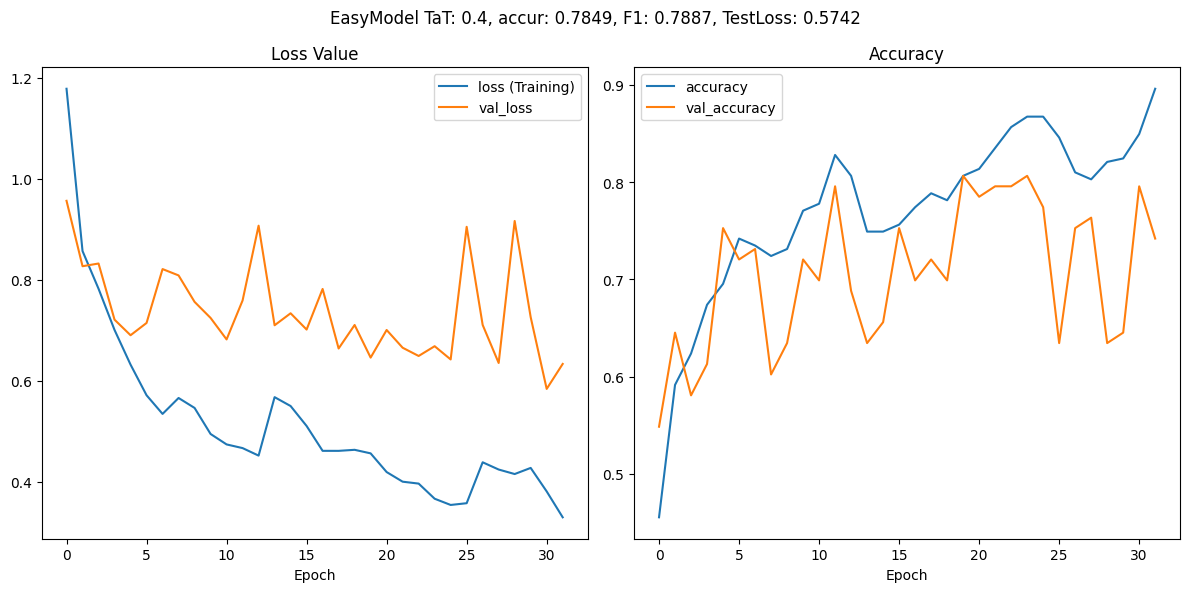

Train loss: 0.32934659719467163
Test val_loss: 0.6330851912498474
Train accuracy: 0.8960573673248291
Accuracy Score: 0.7849462365591398
F1 Score: 0.7887246732283052
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        23
         1.0       0.83      0.80      0.82        25
         2.0       0.86      0.63      0.73        19
         3.0       0.61      0.77      0.68        26

    accuracy                           0.78        93
   macro avg       0.81      0.78      0.79        93
weighted avg       0.80      0.78      0.79        93



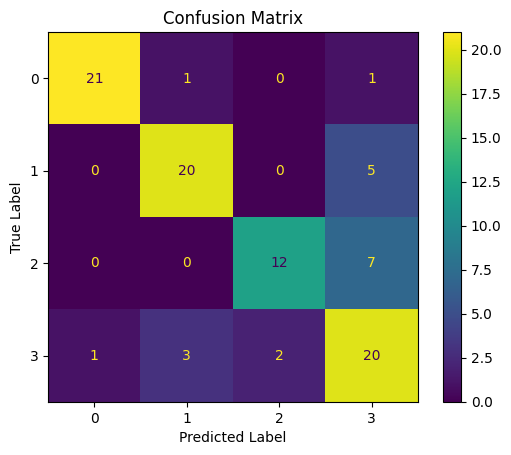

In [2]:
def build_easyModel():
    input_layer = Input(shape=(WS_B, 1))
    x = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)
    model = Model(inputs=[input_layer, input_layer], outputs=output_layer)
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2 CONVs 

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 448, 128)  │      1,408 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 448, 128)  │      1,408 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 224, 128)  │          0 │ conv1d_20[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 224, 128)  │          0 │ conv1d_22[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 221, 64)   │     32,832 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 221, 64)   │     32,832 │ max_pooling1d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 110, 64)   │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 110, 64)   │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 7040)      │          0 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 7040)      │          0 │ max_pooling1d_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 14080)     │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 14080)     │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │    901,184 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        260 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 969,924 (3.70 MB)

 Trainable params: 969,924 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.3344 - loss: 1.3122 - val_accuracy: 0.6022 - val_loss: 0.9044
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6101 - loss: 0.8426 - val_accuracy: 0.5376 - val_loss: 1.0861
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6407 - loss: 0.7769 - val_accuracy: 0.6129 - val_loss: 0.8259
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6595 - loss: 0.7236 - val_accuracy: 0.5914 - val_loss: 0.7704
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7175 - loss: 0.5848 - val_accuracy: 0.6237 - val_loss: 0.7106
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7405 - loss: 0.6007 - val_accuracy: 0.6344 - val_loss: 0.9266
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7341 - loss: 0.6531 - val_accuracy: 0.6559 - val_loss: 0.6943
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7406 - loss: 0.5644 - val_accuracy: 0.7312 - val_loss: 0.6925
Epoch

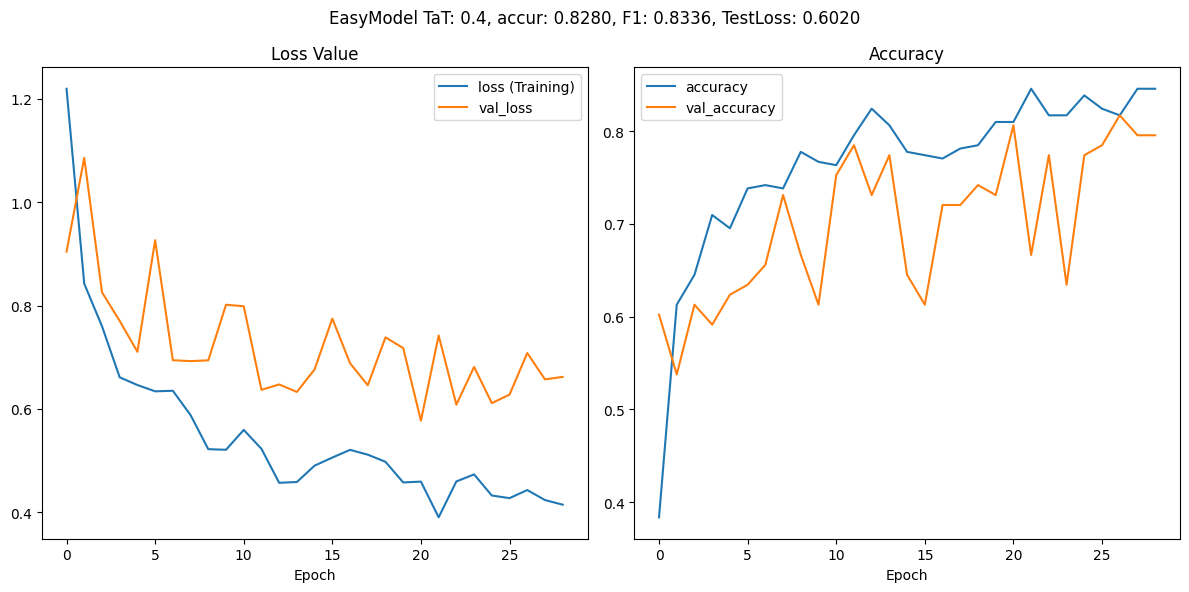

Train loss: 0.41459280252456665
Test val_loss: 0.662005603313446
Train accuracy: 0.8458781242370605
Accuracy Score: 0.8279569892473119
F1 Score: 0.8336075689016865
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91        23
         1.0       0.74      0.80      0.77        25
         2.0       0.85      0.89      0.87        19
         3.0       0.80      0.77      0.78        26

    accuracy                           0.83        93
   macro avg       0.84      0.83      0.83        93
weighted avg       0.83      0.83      0.83        93



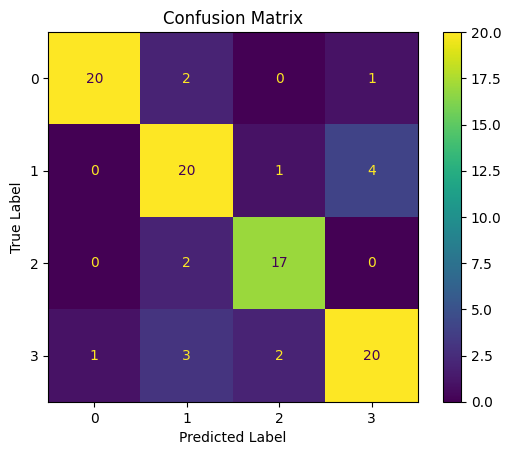

In [7]:
def build_easyModel():
    input = Input(shape=(WS_B, 1))

    x = Conv1D(128, kernel_size=10, strides=4, activation='relu')(input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(128, kernel_size=10, strides=4, activation='relu')(input)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(64, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    merged = Dropout(0.2)(merged)
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input, input], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# model_name = "1D_LDG_F+F_2Cnv_94"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3 CONVs

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 177, 256)  │     10,496 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 177, 256)  │     10,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 88, 256)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 88, 256)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 21, 128)   │    262,272 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 21, 128)   │    262,272 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 10, 128)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 10, 128)   │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 9, 128)    │     32,896 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 9, 128)    │     32,896 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 4, 128)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 4, 128)    │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 512)       │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 512)       │          0 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1024)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    131,200 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 743,044 (2.83 MB)

 Trainable params: 743,044 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
1/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.3438 - loss: 1.3883

2024-05-30 16:32:31.234544: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 593ms/step - accuracy: 0.4113 - loss: 1.2473 - val_accuracy: 0.6774 - val_loss: 0.7756
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7409 - loss: 0.7400 - val_accuracy: 0.8065 - val_loss: 0.5503
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7500 - loss: 0.5698 - val_accuracy: 0.7419 - val_loss: 0.7398
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8013 - loss: 0.5627 - val_accuracy: 0.8280 - val_loss: 0.4499
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8372 - loss: 0.3633 - val_accuracy: 0.8172 - val_loss: 0.4242
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8858 - loss: 0.3063 - val_accuracy: 0.8495 - val_loss: 0.4109
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8907 - loss: 0.2790 - val_accuracy: 0.8065 - val_loss: 0.4254
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8744 - loss: 0.3008 - val_accuracy: 0.8495 - val_loss: 0.4568
Epoch 9/32
9/9 

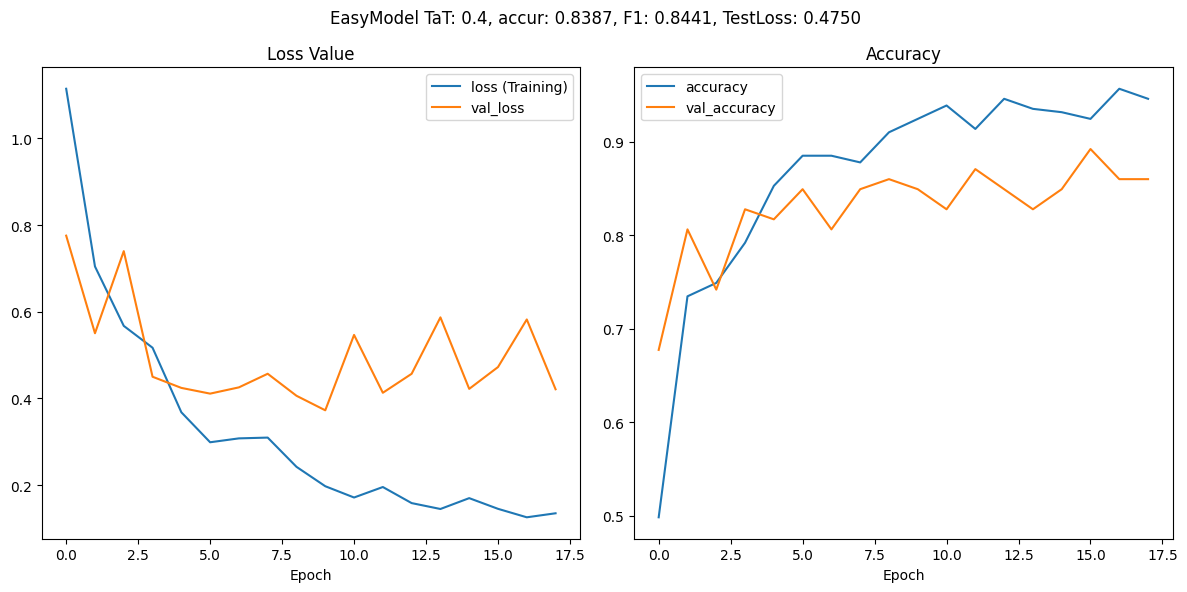

Train loss: 0.1347198784351349
Test val_loss: 0.4210294485092163
Train accuracy: 0.9462365508079529
Accuracy Score: 0.8387096774193549
F1 Score: 0.8441458541458542
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.78      0.86        23
         1.0       0.77      0.92      0.84        25
         2.0       0.90      0.95      0.92        19
         3.0       0.79      0.73      0.76        26

    accuracy                           0.84        93
   macro avg       0.85      0.85      0.84        93
weighted avg       0.85      0.84      0.84        93



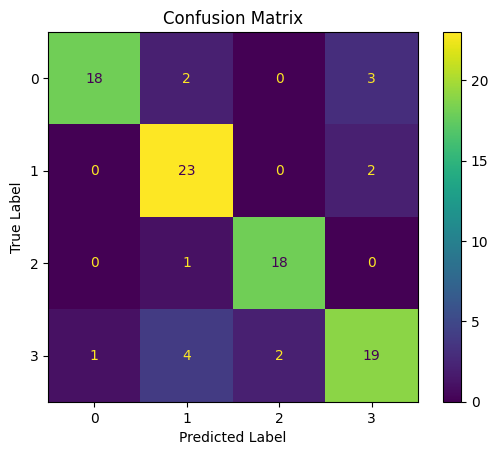

In [5]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    x = Conv1D(256, kernel_size=40, strides=10, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=8, strides=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(256, kernel_size=40, strides=10, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=8, strides=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=2, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(128, activation='relu')(merged)
    common_layer = Dropout(0.2)(common_layer)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4 CONVs or Still "COMPLEX"

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 446, 256)  │      5,376 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 446, 256)  │      5,376 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 223, 256)  │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 223, 256)  │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 52, 256)   │  1,048,832 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 52, 256)   │  1,048,832 │ max_pooling1d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 52, 256)   │          0 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 52, 256)   │          0 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 45, 128)   │    262,272 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 45, 128)   │    262,272 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 22, 128)   │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 22, 128)   │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 19, 64)    │     32,832 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 19, 64)    │     32,832 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 9, 64)     │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 9, 64)     │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 576)       │          0 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 576)       │          0 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1152)      │          0 │ flatten_6[0][0],

 Total params: 2,772,676 (10.58 MB)

 Trainable params: 2,772,676 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


2024-05-30 16:32:41.648825: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 40.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3381 - loss: 1.3255 - val_accuracy: 0.5914 - val_loss: 0.9103
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6505 - loss: 0.8544 - val_accuracy: 0.6237 - val_loss: 0.8466
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7451 - loss: 0.6920 - val_accuracy: 0.7419 - val_loss: 0.6252
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8089 - loss: 0.5263 - val_accuracy: 0.6452 - val_loss: 0.7351
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8269 - loss: 0.4348 - val_accuracy: 0.7419 - val_loss: 0.5416
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8296 - loss: 0.3764 - val_accuracy: 0.7849 - val_loss: 0.6391
Epoch 7/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8975 - loss: 0.2854 - val_accuracy: 0.7849 - val_loss: 0.6024
Epoch 8/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8893 - loss: 0.2920 - val_accuracy: 0.7419 - val_loss: 0.6533
Epoch 9/32
5

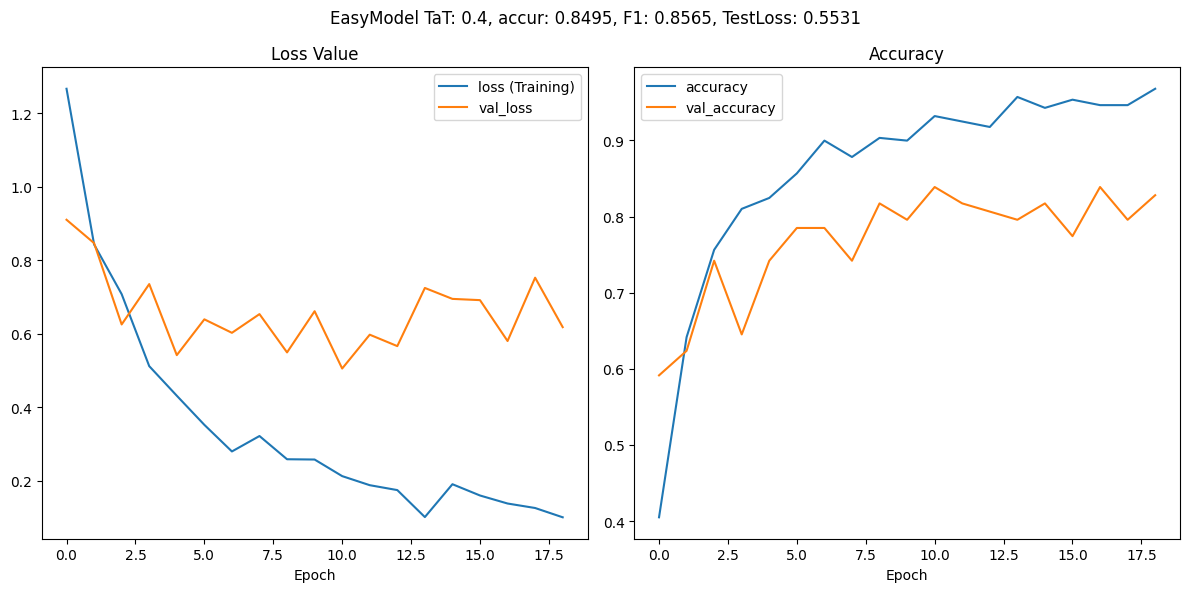

Train loss: 0.0999884232878685
Test val_loss: 0.617850661277771
Train accuracy: 0.9677419066429138
Accuracy Score: 0.8494623655913979
F1 Score: 0.8564963103837535
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        23
         1.0       0.82      0.92      0.87        25
         2.0       1.00      0.89      0.94        19
         3.0       0.72      0.88      0.79        26

    accuracy                           0.85        93
   macro avg       0.89      0.85      0.86        93
weighted avg       0.87      0.85      0.85        93



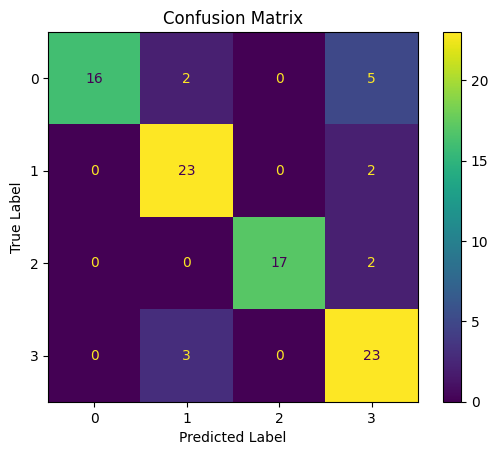

In [6]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    # Branch for Force_X
    x = Conv1D(filters=256, kernel_size=20, strides=4, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    # Branch for Force_Z
    z = Conv1D(filters=256, kernel_size=20, strides=4, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')(z)
    z = Dropout(rate=0.1)(z)
    z = Conv1D(filters=128, kernel_size=8, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=64, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    # Merging branches
    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model


model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=64, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 CONVS